In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
# Libraries importation
import os # operating system interfaces
from os.path import join
from glob import glob
import numpy as np # scientific computing
import pandas as pd # data analysis
import tensorflow as tf
import matplotlib.pyplot as plt # plots
import PIL # image files manipulation
import random

# callback to reduce learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

# opencv to handle images (https://opencv.org/releases/)
import cv2 as cv

# print metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, \
    confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
# Load the TensorBoard notebook extension

from gc import callbacks
import datetime, os
from keras.callbacks import *

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)


Number of replicas: 1
2.8.2


# Parameters selection

In [ ]:
IMG_SIZE= (1000, 1000)

In [ ]:
filename= 'celiacdiseace_fine_tuned_SparseCategoricalCrossentropy_ADAM_50_epoch_estop_5_batch8'
file_path = '/content/drive/MyDrive/CD/train'

#Data preparation

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=1234
batch_size= 8
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

In [ ]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/CD/train",
                                                           seed=seed,
                                                           batch_size=batch_size)

Found 103 images belonging to 3 classes.


In [ ]:
print(image_generator.class_indices)

{'marsh1': 0, 'marsh2': 1, 'normal': 2}


In [ ]:
class_labels = image_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

{0: 'marsh1', 1: 'marsh2', 2: 'normal'}


In [ ]:
# Split train and validation data
train_dir= '/content/drive/MyDrive/CD/train'
val_dir = '/content/drive/MyDrive/CD/val'
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size = IMG_SIZE,
                                                         batch_size = batch_size,
                                                         )

val_data = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                       image_size = IMG_SIZE,
                                                       batch_size = batch_size,
                                                       )

Found 103 files belonging to 3 classes.
Found 12 files belonging to 3 classes.


In [ ]:
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(val_data)}")

total train data per batch: 13
total validation data per batch: 2


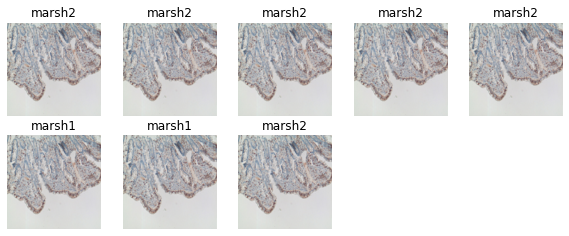

In [ ]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(batch_size):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
# create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)


In [ ]:
# preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet'
                                         )

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1000, 1000, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1000, 1000, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 500, 500, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 500, 500, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 500, 500, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 250, 250, 128)     0     

In [ ]:
# Freeze the entire base_model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1000, 1000, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1000, 1000, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 500, 500, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 500, 500, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 500, 500, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 250, 250, 128)     0     

In [ ]:
# set variable for classfier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# set variable for output layer
nClass = len(class_names)
prediction_layer = tf.keras.layers.Dense(nClass, activation = 'softmax')

In [ ]:
# re-construct the model
inputs = tf.keras.Input(shape = (1000,1000,3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [ ]:
checks= '/content/drive/MyDrive/stage_juin/weights/logs_fn/{}'.format(filename)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5),
     TensorBoard(log_dir=checks)
]

In [ ]:
# check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 tf.__operators__.getitem (S  (None, 1000, 1000, 3)    0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 1000, 1000, 3)    0         
                                                                 
 vgg16 (Functional)          (None, 31, 31, 512)       14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

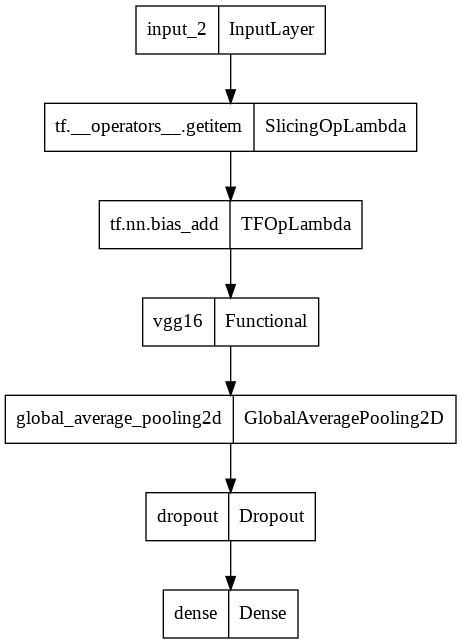

In [ ]:
tf.keras.utils.plot_model(model)

#Training part !

In [ ]:
# start train the model
initial_epochs= 30
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = [callbacks])

Epoch 1/30
13/13 [==============================] - 21s 2s/step - loss: 1.0667 - accuracy: 0.5340 - val_loss: 1.1369 - val_accuracy: 0.5000
Epoch 2/30
13/13 [==============================] - 22s 2s/step - loss: 1.0361 - accuracy: 0.5631 - val_loss: 1.0577 - val_accuracy: 0.5000
Epoch 3/30
13/13 [==============================] - 21s 2s/step - loss: 1.0006 - accuracy: 0.5340 - val_loss: 1.0711 - val_accuracy: 0.5000
Epoch 4/30
13/13 [==============================] - 21s 2s/step - loss: 1.0038 - accuracy: 0.5631 - val_loss: 1.0122 - val_accuracy: 0.5000
Epoch 5/30
13/13 [==============================] - 21s 2s/step - loss: 1.0245 - accuracy: 0.5631 - val_loss: 1.0254 - val_accuracy: 0.5000
Epoch 6/30
13/13 [==============================] - 21s 2s/step - loss: 0.9998 - accuracy: 0.5631 - val_loss: 1.0154 - val_accuracy: 0.5000



another solution to try further if the error is : WARNING:tensorflow:Your input ran out of data!


```
TRAIN_STEPS_PER_EPOCH = np.ceil((image_count*0.8/BATCH_SIZE)-1)
# to ensure that there are enough images for training bahch
VAL_STEPS_PER_EPOCH = np.ceil((image_count*0.2/BATCH_SIZE)-1)



history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        epochs=EPOCHS,
        verbose = 1,
        validation_data=val_ds,
        validation_steps=VAL_STEPS_PER_EPOCH,
        callbacks=tensorboard_callback)
```



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


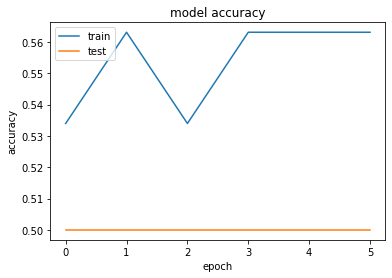

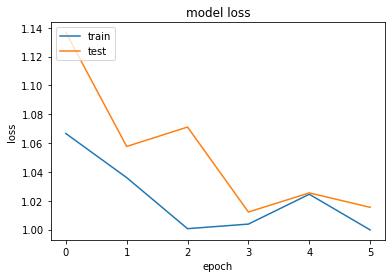

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
checks

In [ ]:
# View training accuracy and loss graph via tensorboard
%tensorboard --logdir checks

In [ ]:
base_model.trainable = True

In [ ]:
# let's take a look at the model layers
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10

# Freeze all the layer before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# compile the model again
# As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.1),
              metrics = ['accuracy'])

In [ ]:
# lets check the model again
model.summary()

In [ ]:
# Now, we resume the model trianing from the last epochs
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# train the model again
histroy_fine_tune = model.fit(train_data,
                              epochs = total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_data = val_data,
                              callbacks = [callbacks])

In [ ]:
%cd /content/drive/MyDrive/stage_juin/weights


In [ ]:
model.save(filename+'.h5')

In [ ]:
# View training accuracy and loss graph via tensorboard
%tensorboard --logdir logs_fn

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Testing part !

##load the test data

In [ ]:
test_dir= '/content/drive/MyDrive/CD/test'
test_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size = IMG_SIZE,
                                                         batch_size = batch_size,
                                                         )


In [ ]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

In [ ]:
# Use test data to make prediction
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

In [ ]:
len(test_data)

le nombre des images classifiée correctement sont : 5/8
le nombre des images mal classifiée sont : 3/8


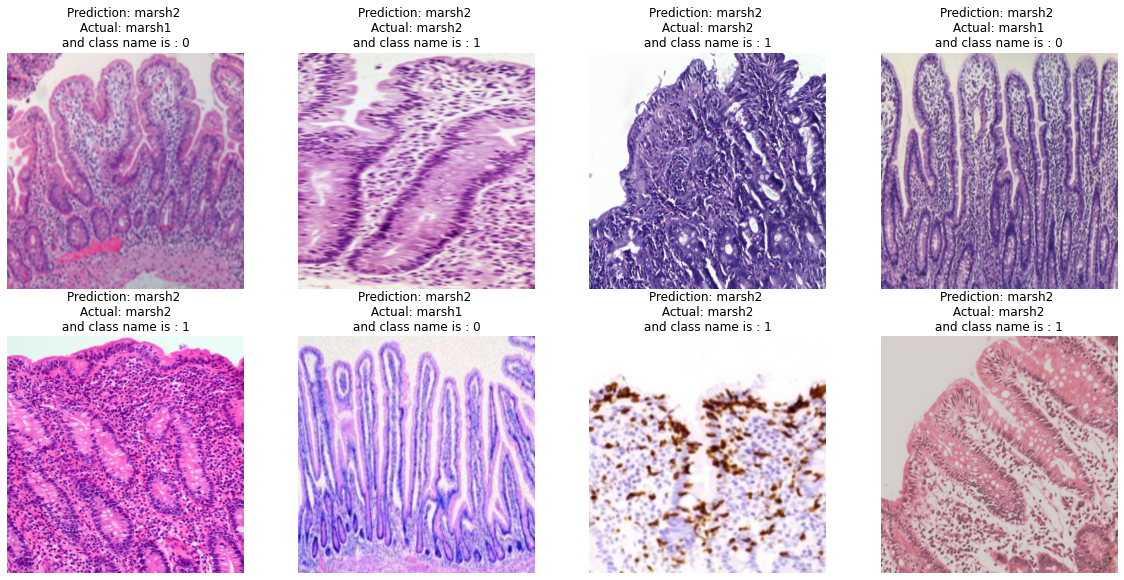

In [ ]:
# plot the prediction vs actual label
x= 0
y = 0
plt.figure(figsize = (20,20))
for i in range(batch_size):
  axs = plt.subplot(4,4,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  current_prediction = class_names[class_predictions[i]]
  current_label = class_names[label_batch[i]]
  plt.title(f"Prediction: {current_prediction} \n Actual: {current_label} \n and class name is : {label_batch[i]} ")
  plt.axis('off')
  if current_prediction == current_label:
    x += 1
  else:
    y +=1
print('le nombre des images classifiée correctement sont : '+str(x)+'/'+ str(batch_size))
print('le nombre des images mal classifiée sont : '+str(y)+'/'+ str(batch_size))

In [ ]:
%cd /content/drive/MyDrive/stage_juin/weights

/content/drive/.shortcut-targets-by-id/1CIsMGoCgMLI4piidLkprV5-Wooe6wF4p/stage_juin/weights


In [ ]:
model.save('final_vgg16_pretrained.h5')

#Evaluation part

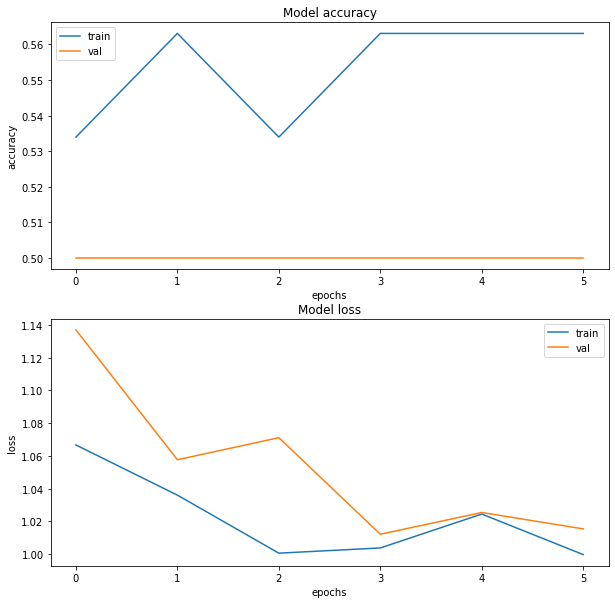

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])



In [ ]:
## TEST SET
'''test_concat = pd.concat([mild_test, moderate_test, non_test, verymild_test])
test_concat = test_concat.sample(frac=1)
test_concat["X"] = test_concat["X"].apply(load_image)
test_concat["y"] = test_concat["y"].apply(hot_array)
xtest = np.stack(val_concat["X"])
ytest = np.stack(val_concat["y"])'''

'test_concat = pd.concat([mild_test, moderate_test, non_test, verymild_test])\ntest_concat = test_concat.sample(frac=1)\ntest_concat["X"] = test_concat["X"].apply(load_image)\ntest_concat["y"] = test_concat["y"].apply(hot_array)\nxtest = np.stack(val_concat["X"])\nytest = np.stack(val_concat["y"])'

In [ ]:
# evaluation
_ = model.evaluate(test_data)

In [ ]:
# Function from Federico Agostini notebooks (slightly modified)

def print_metrics(model, X, y, cm_labels="auto"):
    """
    Print the following metrics: accuracy, balanced accuracy, precision, recall, f1.
    If the model is able to predict probabilities, also auc is calculated.
    Moreover, the confusion matrix is plotted.

    Parameters
    ----------
    model : sklearn estimator
        Sklearn estimator or similar which implements the method `predict`
        and optionally `predict_proba`.
    X : array like
        Input features.
    y : array like
        Target labels.
    cm_labels : list [default="auto"]
        Optional labels to be used in the confusion matrix.

    Returns
    -------
    metrics : dict
        Dictionary with the calculated metrics.

    """
    y_pred = model.predict(X)
    y_pred = np.squeeze(y_pred)
    y_pred = np.argmax(y_pred,1).astype(int)

    metrics = {
        "Accuracy"    : accuracy_score(y, y_pred),
        "Bal Accuracy": balanced_accuracy_score(y, y_pred),
        "Precision"   : precision_score(y, y_pred, average="macro"),
        "Recall"      : recall_score(y, y_pred, average="macro"),
        "f1"          : f1_score(y, y_pred, average="macro")
    }
    # add AUC if the classifier is able to predict probabilities
    try:
        y_pred_proba = model.predict_proba(X)
        metrics["AUC"] = roc_auc_score(y, y_pred_proba, multi_class="ovr", average="macro")
    except:
        metrics["AUC"] = np.nan

    for k,v in metrics.items():
        print("{:12s} = {}".format(k,v))
    print("\n")

    # confusion matrix
    cm = confusion_matrix(y, y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(cm, ax=ax, square=True, vmin=0, vmax=1, annot=True,
                linewidths=.05, fmt=".2f", cbar_kws={"shrink":.8},
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xticks([0.5, 1.5], ['NORMAL', 'PNEUMONIA'])
    plt.yticks([0.5, 1.5], ['NORMAL', 'PNEUMONIA'])
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    metrics["cm"] = cm

    return metrics